**Import Libaries**

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pytz
import numpy as np

In [55]:
data_posts_hashtags_raw = pd.read_csv("../data/posts_transcripts_raw.csv")
data_posts_hashtags = data_posts_hashtags_raw.drop(columns = ['post_id'])
data_posts_hashtags['text'][0]

'Werbung | Garnier Bereit für die perfekte Winterpflege? ❄️✨ Mit der Garnier Skin Cycling Routine bringst Du Deine Haut zum Strahlen – einfach und effektiv! Ich starte meine Pflege mit der Garnier Retinol Tuchmaske. Sie ist mein absolutes Highlight, denn sie regeneriert meine Haut intensiv und sorgt sofort für einen frischen, strahlenden Teint. Der perfekte erste Schritt, um die Haut zu verwöhnen und optimal vorzubereiten! Nach der Maske trage ich das Garnier AHA + BHA Serum auf. Es reinigt die Haut tiefenwirksam und hilft, einen klaren, lebendigen Teint zu bewahren – ideal, um der Haut einen natürlichen Glow zu verleihen. Zum Schluss kommt das Hautklar Daily UV Fluid, das meine Haut zuverlässig vor schädlichen UV-Strahlen schützt – auch im Winter! Es ist leicht, zieht schnell ein und ist der perfekte Abschluss meiner Routine. Diese drei Produkte sind perfekt aufeinander abgestimmt und machen meine Winterpflege kinderleicht. Frisch, vital und strahlend – so sieht meine Haut auch an kal

12271 rows

**Data preperation**

In [56]:
# Count NaNs per column
nan_counts = data_posts_hashtags.isna().sum()

# Count unique values per column
unique_counts = data_posts_hashtags.nunique()

# Combine into one table
summary = pd.DataFrame({
    'NaNs': nan_counts,
    'Unique Values': unique_counts
})

print(summary)

                      NaNs  Unique Values
text                   177          15619
textLanguage             1             76
createTimeISO            0          16028
isAd                     0              2
author_nickName          0           8928
author_signature       729           9021
author_fans              0           6822
video_duration           0            443
diggCount                0           6080
shareCount               0           3737
playCount                0           6944
collectCount             0           4972
commentCount             0           2586
isSponsored              0              2
searchHashtag_name       0              4
searchHashtag_views      0            287
location_address     13164            665
detected_language     3803             99
transcribed_text      4091          10847
video_description     3690          12005


isMuted, location_address, author_ttSeller have a lot of NaNs. 


In [58]:
data_posts_hashtags["createTimeISO"] = pd.to_datetime(data_posts_hashtags["createTimeISO"])
data_posts_hashtags["country"] = data_posts_hashtags["location_address"].str.extract(r',\s*([^,]+)$')

**Language distribution**

In [59]:
# Count languages
lang_counts = data_posts_hashtags['textLanguage'].value_counts()

# Convert to DataFrame and calculate percentage
lang_dist = lang_counts.reset_index()
lang_dist.columns = ['Language', 'Count']
lang_dist['Percentage'] = (lang_dist['Count'] / lang_dist['Count'].sum()) * 100

# Sort by most common
lang_dist = lang_dist.sort_values(by='Count', ascending=False).reset_index(drop=True)

# Display top 5
lang_dist.head(5)

,Language,Count,Percentage
0,en,7344,45.759860
1,de,4900,30.531497
2,un,1649,10.274783
3,id,453,2.822606
4,es,388,2.417596


75% of all posts are in German in English therefore we will from know on limit our analysis to those two languages

In [60]:
data_english = data_posts_hashtags[data_posts_hashtags.textLanguage.isin(['en'])]
data_german = data_posts_hashtags[data_posts_hashtags.textLanguage.isin(['de'])]

In [ ]:
from langdetect import detect

def detect_language(text):
    try:
        return detect(text)
    except:
        return np.nan 

In [ ]:
data_posts_hashtags['lang_transcripts'] = data_posts_hashtags['transcribed_text'].apply(detect_language)

lang_counts = data_posts_hashtags['lang_transcripts'].value_counts()

plt.figure(figsize=(8,4))
lang_counts.plot(kind='bar')
plt.title('Language Distribution in Post Transcripts')
plt.xlabel('Language')
plt.ylabel('Number of Posts')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Content with advertisements**

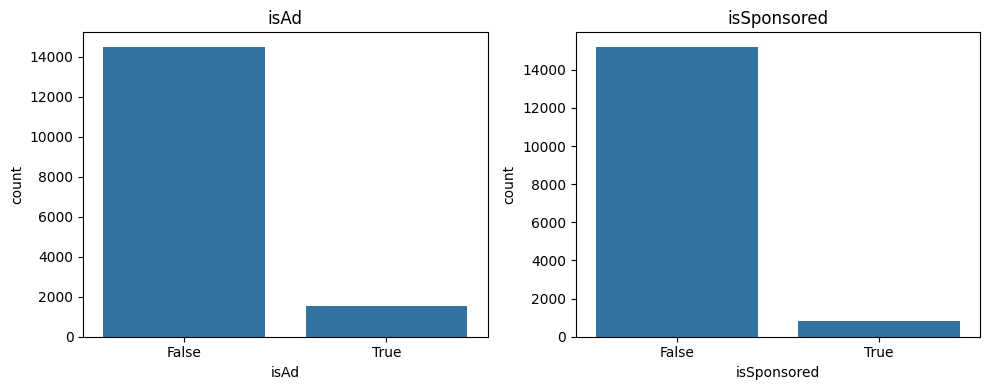

In [61]:
cols = ["isAd", "isSponsored"]

plt.figure(figsize=(10, 4))
for i, col in enumerate(cols, 1):
    plt.subplot(1, 2, i)
    sns.countplot(x=col, data=data_posts_hashtags)
    plt.title(col)

plt.tight_layout()
plt.show()

Nearly all of the data are not ads nor sponsored. 582 rows is_ad and is_sponsred is different. This makes only 5.5%. Meaning for 95% of the data is_ad equals to is_sponsored

**Success metrics**

In [62]:
metrics = ["playCount", "diggCount", "commentCount", "collectCount", "shareCount"]

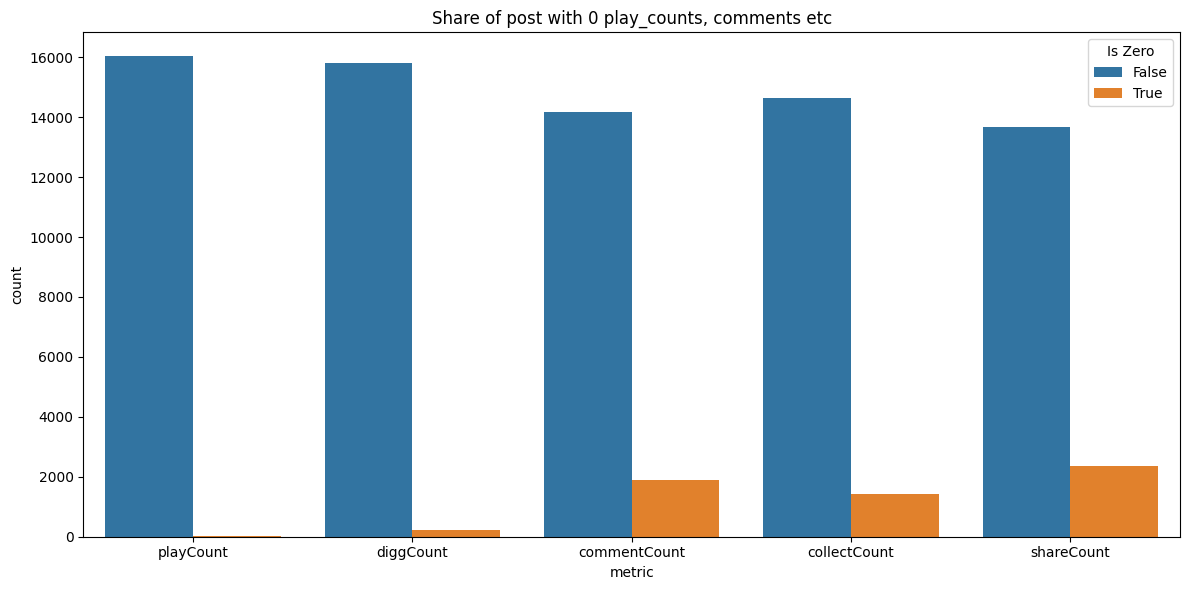

In [63]:
# Create a melted DataFrame with a new column "is_zero"
metrics_is_zero = data_posts_hashtags[metrics].melt(var_name="metric", value_name="value")
metrics_is_zero["is_zero"] = metrics_is_zero["value"] == 0

plt.figure(figsize=(12, 6))
sns.countplot(data=metrics_is_zero, x="metric", hue="is_zero")
plt.title("Share of post with 0 play_counts, comments etc")
plt.legend(title="Is Zero")
plt.tight_layout()
plt.show()

In [64]:
(data_posts_hashtags["playCount"] == 0).sum()

21

We can see that there is a quite high share of posts which have no comments etc

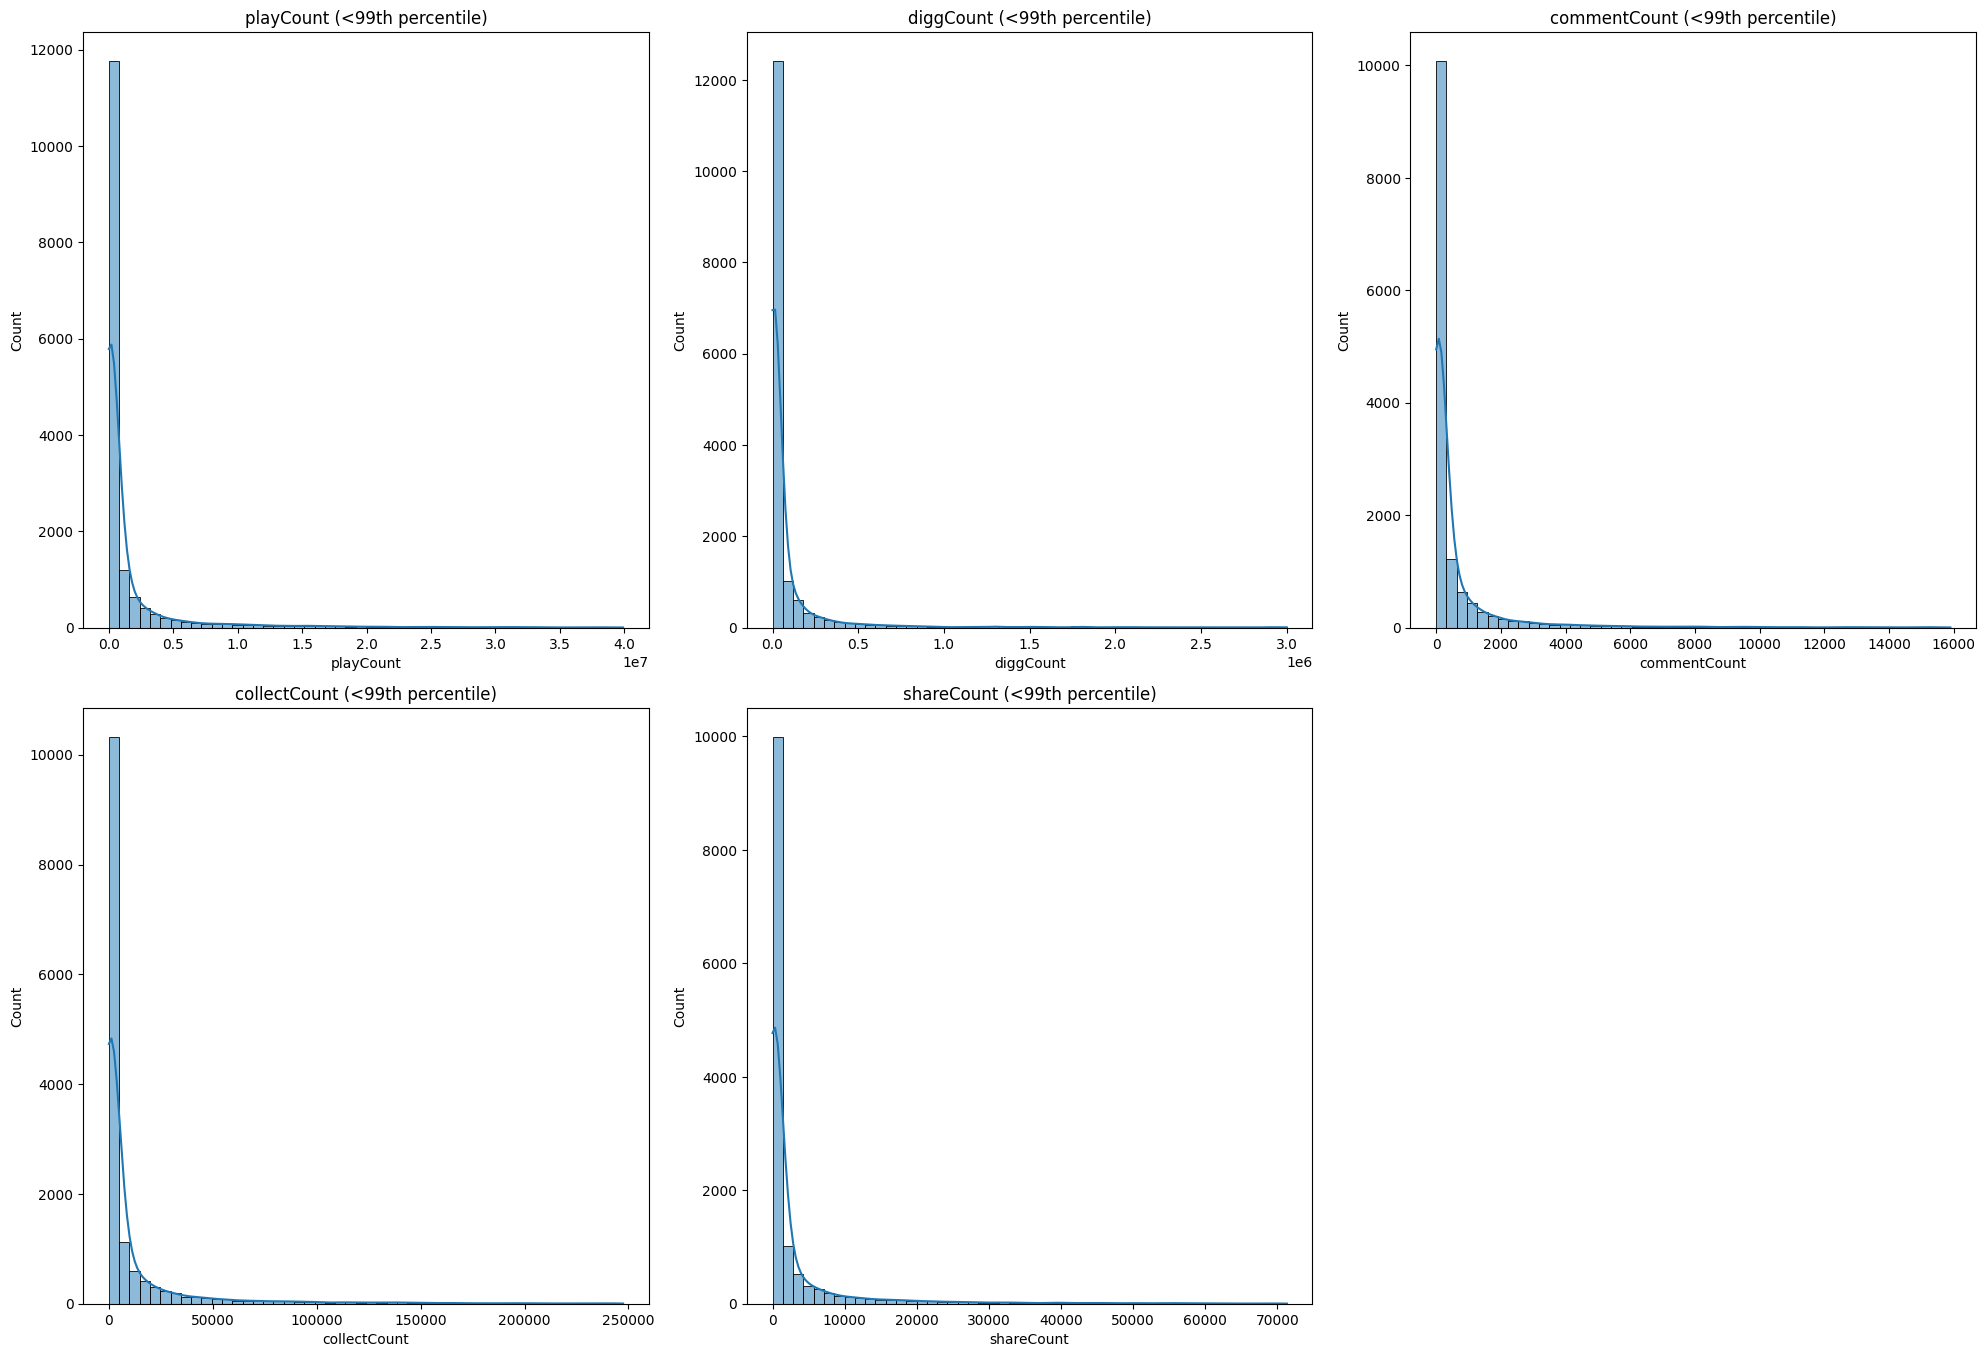

In [65]:
plt.figure(figsize=(20, 20))
for i, col in enumerate(metrics, 1):
    plt.subplot(3, 3, i)
    q99 = data_posts_hashtags[col].quantile(0.99)
    filtered = data_posts_hashtags[(data_posts_hashtags[col] > 0) & (data_posts_hashtags[col] < q99)]
    sns.histplot(filtered[col], bins=50, kde=True)
    plt.title(f"{col} (<99th percentile)")

plt.tight_layout()
plt.show()

The success metrics are gighly skweded 

In [66]:
for col in metrics:
    q99 = data_posts_hashtags[col].quantile(0.99)
    max_val = data_posts_hashtags[col].max()
    print(f"{col}: 99th perc.:{q99:.0f}, max: {max_val}")

playCount: 99th perc.:39951000, max: 371400000
diggCount: 99th perc.:3100000, max: 18900000
commentCount: 99th perc.:15951, max: 240400
collectCount: 99th perc.:247910, max: 1900000
shareCount: 99th perc.:71600, max: 2800000


**Video duration**

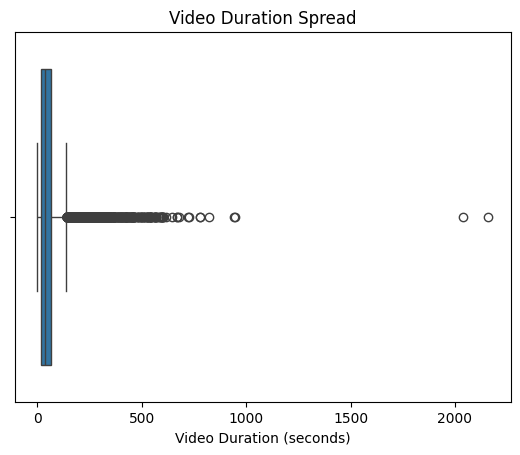

In [67]:
sns.boxplot(x=data_posts_hashtags["video_duration"])
plt.title("Video Duration Spread")
plt.xlabel("Video Duration (seconds)")
plt.show()

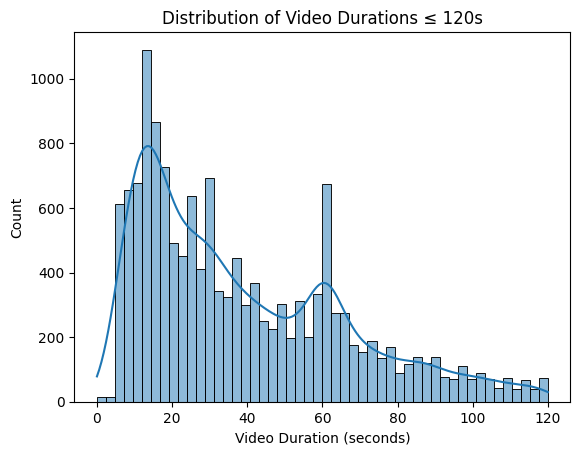

In [68]:
filtered = data_posts_hashtags[data_posts_hashtags["video_duration"] <= 120]
sns.histplot(filtered["video_duration"], bins=50, kde=True)
plt.title("Distribution of Video Durations ≤ 120s")
plt.xlabel("Video Duration (seconds)")
plt.ylabel("Count")
plt.show()

**From where are our posts**

In [69]:
data_posts_hashtags["country"].unique()

array([nan, 'Germany', 'Deutschland', 'United States', 'Indonesia',
       'Australia', 'USA', 'Austria', 'Japan', 'Österreich', 'Canada',
       'Greece', 'المملكة العربية السعودية', 'Nigeria', 'Nederland',
       'France', 'Switzerland', 'Sweden', 'Pakistan', 'Netherlands',
       'Saudi Arabia', 'United Kingdom', 'Spain', 'South Africa',
       'Bangkok 10300 Thailand', 'Brazil', 'مصر', 'Mexico', 'UK',
       'Seongdong Sangwon 2-gil 7-10', 'Emirates',
       'الإمارات العربية المتحدة', 'Egypt', 'Polska', 'Philippines',
       'Czech Republic', 'United Arab Emirates', 'Poland', 'Malaysia',
       'Brasil', 'Mandarin Oriental Hotel Mandarin Oriental', 'Algeria',
       'España', 'Türkiye', 'Schweiz', 'Turkey', 'Czechia', 'Italy',
       'Republic of Indonesia', 'Denmark', 'South Korea', 'Colombia',
       'Italia', 'Kenya', 'Hungary', 'Thailand', 'Slovenia', 'Singapore',
       'Norway', 'Bangladesh', 'Damansara Jaya', 'New Zealand', 'Seoul',
       'Seongdong', 'Argentina'], dtype=o

In [70]:
country_fix = {
    "Deutschland": "Germany",
    "Österreich": "Austria",
    "UK": "United Kingdom",
    "USA": "United States",
    "Brasil": "Brazil",
    "Italia": "Italy",
    "مصر": "Egypt",
    "المملكة العربية السعودية": "Saudi Arabia",
    "Turkey": "Türkiye",
    "Bangkok 10300 Thailand": "Thailand",
    "Mandarin Oriental Hotel Mandarin Oriental": None,  # unclear
}

# Apply the fixes
data_posts_hashtags["country_clean"] = data_posts_hashtags["country"].replace(country_fix)

In [71]:
timezone_map = {
    "Germany": "Europe/Berlin",
    "France": "Europe/Paris",
    "Türkiye": "Europe/Istanbul",
    "Saudi Arabia": "Asia/Riyadh",
    "United States": "America/New_York",  # default — or map by state later
    "Canada": "America/Toronto",
    "Switzerland": "Europe/Zurich",
    "South Korea": "Asia/Seoul",
    "Pakistan": "Asia/Karachi",
    "Indonesia": "Asia/Jakarta",
    "Greece": "Europe/Athens",
    "Philippines": "Asia/Manila",
    "Sweden": "Europe/Stockholm",
    "Kenya": "Africa/Nairobi",
    "Egypt": "Africa/Cairo",
    "South Africa": "Africa/Johannesburg",
    "Austria": "Europe/Vienna",
    "United Kingdom": "Europe/London",
    "Nigeria": "Africa/Lagos",
    "Poland": "Europe/Warsaw",
    "Bangladesh": "Asia/Dhaka",
    "Australia": "Australia/Sydney",
    "Brazil": "America/Sao_Paulo",
    "Colombia": "America/Bogota",
    "United Arab Emirates": "Asia/Dubai",
    "Italy": "Europe/Rome",
    "Czechia": "Europe/Prague",
    "Thailand": "Asia/Bangkok",
    "Mexico": "America/Mexico_City",
    "Nederland": "Europe/Amsterdam",
    "Japan": "Asia/Tokyo",
    "Algeria": "Africa/Algiers"
}


In [72]:
# Convert createTimeISO to UTC datetime
data_posts_hashtags['utc_time'] = pd.to_datetime(data_posts_hashtags['createTimeISO'], utc=True)

# Calculate local time for valid countries
data_posts_hashtags['local_time'] = [
    utc.astimezone(pytz.timezone(timezone_map[country])) if pd.notna(country) and country in timezone_map else pd.NaT
    for utc, country in zip(data_posts_hashtags['utc_time'], data_posts_hashtags['country'])
]

# Extract hours
data_posts_hashtags['hour'] = data_posts_hashtags['local_time'].astype(str).str.extract(r'(\d{2}):')[0].astype('Int64')


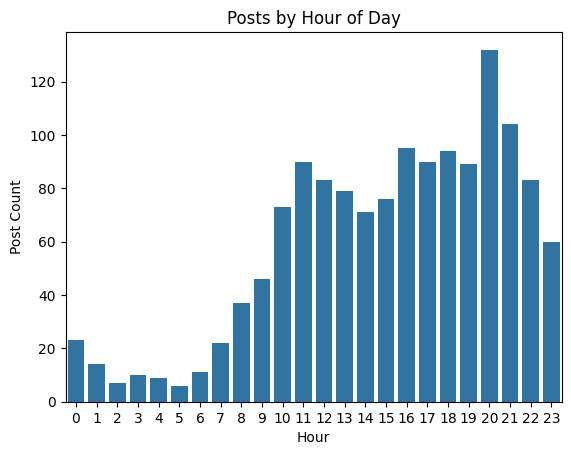

In [73]:
sns.countplot(x="hour", data=data_posts_hashtags)
plt.title("Posts by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Post Count")
plt.show()

People post most often in the evening between 20:00 to 22:00. During the night there are the least posts.

**From when are our posts**

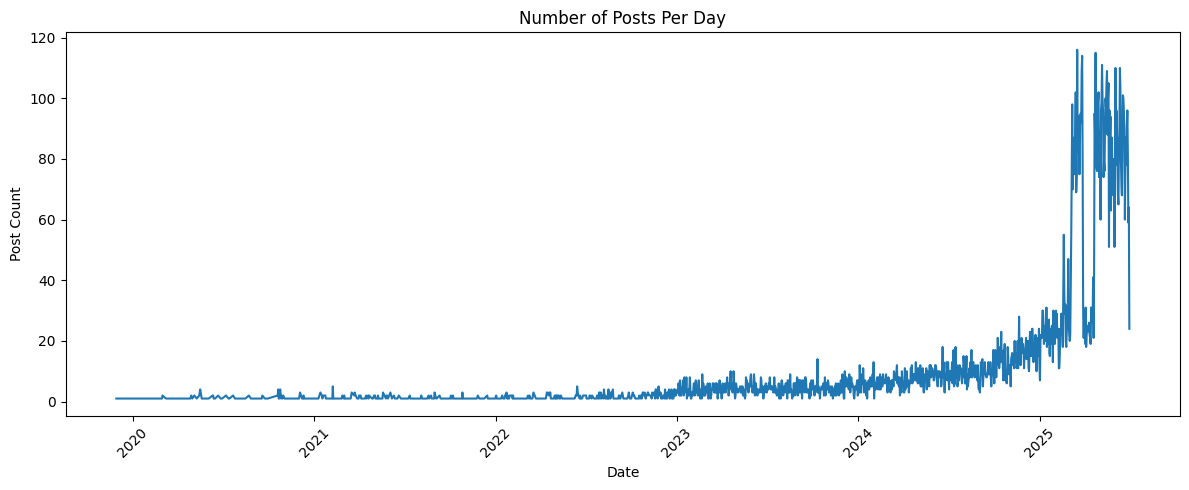

In [74]:
posts_per_day = data_posts_hashtags["createTimeISO"].dt.date.value_counts().sort_index()

plt.figure(figsize=(12, 5))
posts_per_day.plot()
plt.title("Number of Posts Per Day")
plt.xlabel("Date")
plt.ylabel("Post Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

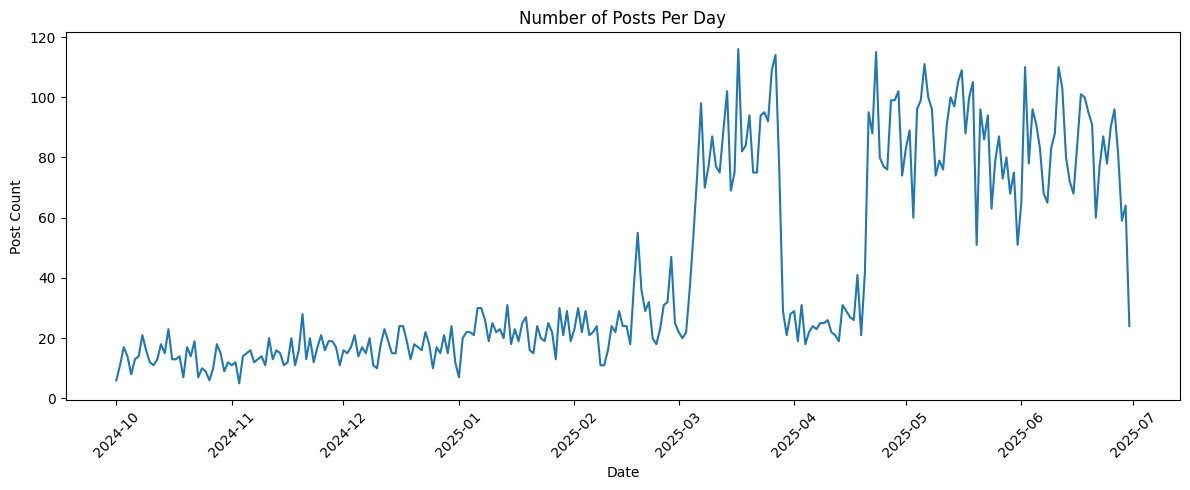

In [75]:
mask = data_posts_hashtags["createTimeISO"].dt.date >= pd.to_datetime("2024-10-01").date()
posts_per_day = data_posts_hashtags.loc[mask, "createTimeISO"].dt.date.value_counts().sort_index()

plt.figure(figsize=(12, 5))
posts_per_day.plot()
plt.title("Number of Posts Per Day")
plt.xlabel("Date")
plt.ylabel("Post Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In future analysis we will focus only on posts from 2025 to keep the data consistent and ensure it reflects the most relevant trends and behaviors.

**Posts per weekday**

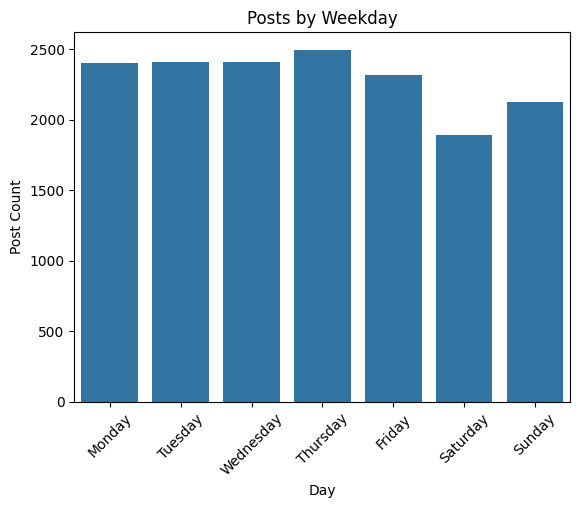

In [76]:
data_posts_hashtags["weekday"] = data_posts_hashtags["createTimeISO"].dt.day_name()

sns.countplot(x="weekday", data=data_posts_hashtags,
              order=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
plt.title("Posts by Weekday")
plt.xlabel("Day")
plt.ylabel("Post Count")
plt.xticks(rotation=45)
plt.show()


**Influencer analysis**

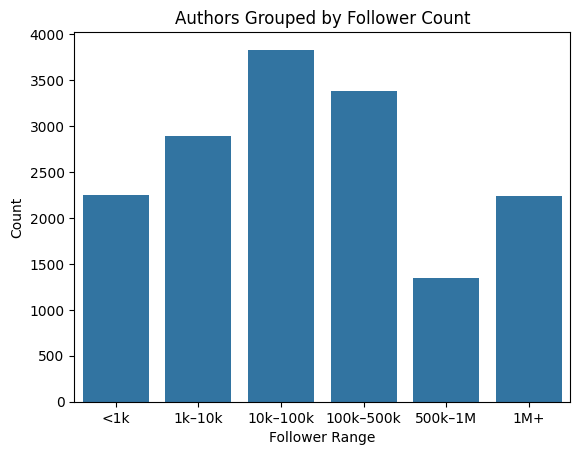

In [77]:
bins = [0, 1_000, 10_000, 100_000,500_000, 1_000_000, np.inf]
labels = ['<1k', '1k–10k', '10k–100k', '100k–500k', '500k–1M', '1M+']
data_posts_hashtags['fans_bin'] = pd.cut(data_posts_hashtags['author_fans'], bins=bins, labels=labels)

sns.countplot(x='fans_bin', data=data_posts_hashtags)
plt.title("Authors Grouped by Follower Count")
plt.xlabel("Follower Range")
plt.ylabel("Count")
plt.show()

### Hashtags Exploration

**Hashtags that were searched for**

/var/folders/rx/4hst61c96_bfm0gnxrq_5w_h0000gn/T/ipykernel_73744/172753211.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=search_hashtag_counts.values, y=search_hashtag_counts.index, palette="pastel")


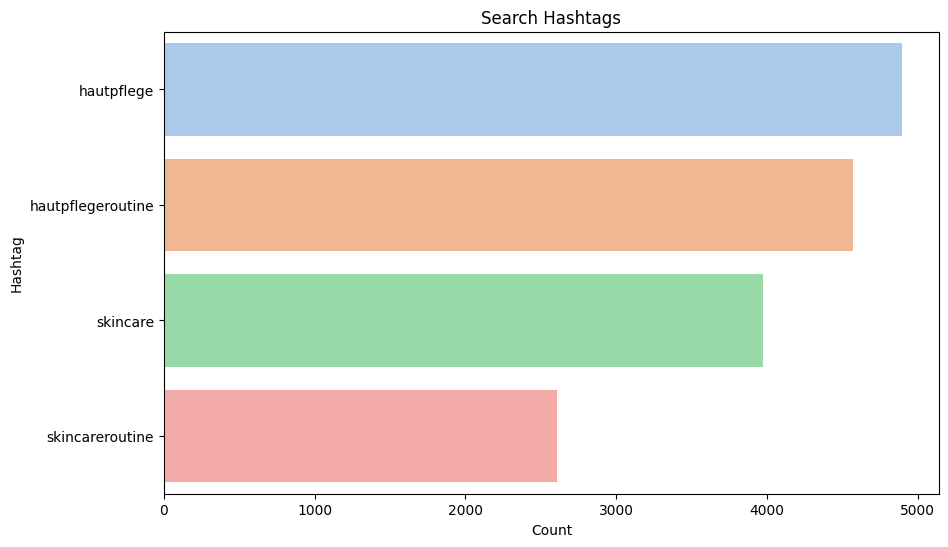

In [78]:
unique_searchhashtags = data_posts_hashtags['searchHashtag_name'].unique() 

search_hashtag_counts = data_posts_hashtags.searchHashtag_name.value_counts()

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=search_hashtag_counts.values, y=search_hashtag_counts.index, palette="pastel")
plt.title("Search Hashtags")
plt.xlabel("Count")
plt.ylabel("Hashtag")
plt.show()

**Most common and engaging hashtags**

Sidenote: Looking in Bigquery found out that search_hashtag is actually not always part of the hashtags

In [79]:
data_hashtags = pd.read_csv("../data/hashtags_posts.csv")

In [80]:
(data_hashtags['searchHashtag_name'] == data_hashtags['hashtag_name']).sum()

3336

In [ ]:
unique_hashtags = data_hashtags['hashtag_name'].unique() 
len(unique_hashtags)

14627

/var/folders/rx/4hst61c96_bfm0gnxrq_5w_h0000gn/T/ipykernel_73744/2294102834.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=hashtag_counts.values, y=hashtag_counts.index, palette="pastel")


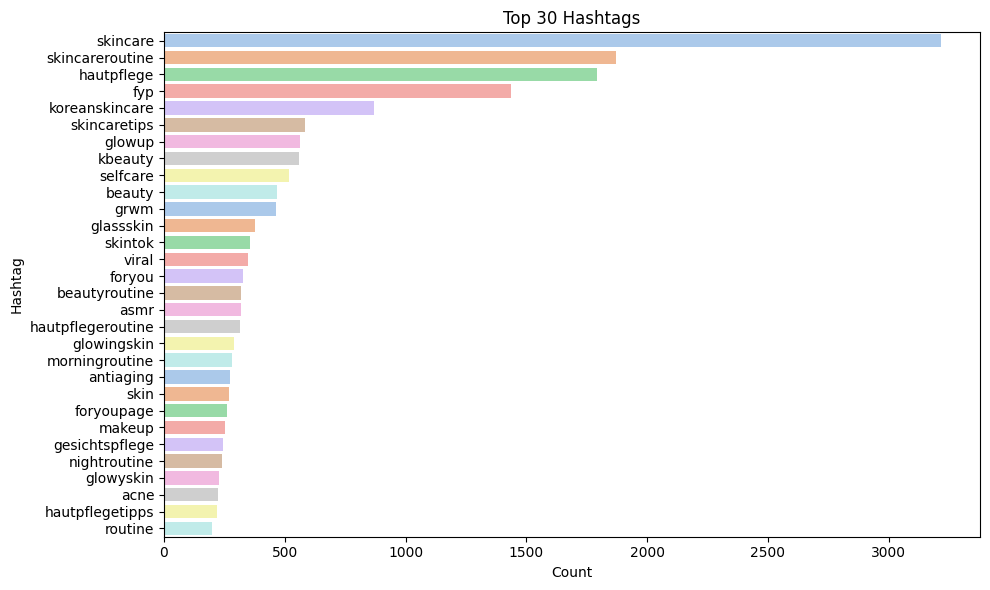

In [89]:
hashtag_counts = data_hashtags.hashtag_name.value_counts().head(30)  # top 30

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=hashtag_counts.values, y=hashtag_counts.index, palette="pastel")
plt.title("Top 30 Hashtags")
plt.xlabel("Count")
plt.ylabel("Hashtag")
plt.tight_layout()
plt.show()

In [90]:
hashtag_post_counts = (
    data_hashtags.groupby('hashtag_name')['post_id']
    .nunique()
    .sort_values(ascending=False)
)

quantiles = hashtag_post_counts.quantile([0.25, 0.5, 0.75, 0.9, 0.95, 0.975, 0.99])
print("Quantils of number of posts per Hashtag:")
print(quantiles)

Quantils of number of posts per Hashtag:
0.250     1.0
0.500     1.0
0.750     2.0
0.900     6.0
0.950    10.0
0.975    20.0
0.990    47.0
Name: post_id, dtype: float64


/var/folders/rx/4hst61c96_bfm0gnxrq_5w_h0000gn/T/ipykernel_73744/2447404667.py:62: UserWarning: Glyph 12471 (\N{KATAKANA LETTER SI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/rx/4hst61c96_bfm0gnxrq_5w_h0000gn/T/ipykernel_73744/2447404667.py:62: UserWarning: Glyph 12442 (\N{COMBINING KATAKANA-HIRAGANA SEMI-VOICED SOUND MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/hannahschlaucher/Library/Caches/pypoetry/virtualenvs/skincare-analysis-pFfgqJ8c-py3.10/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12471 (\N{KATAKANA LETTER SI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/hannahschlaucher/Library/Caches/pypoetry/virtualenvs/skincare-analysis-pFfgqJ8c-py3.10/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12442 (\N{COMBINING KATAKANA-HIRAGANA SEMI-VOICED SOUND MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw

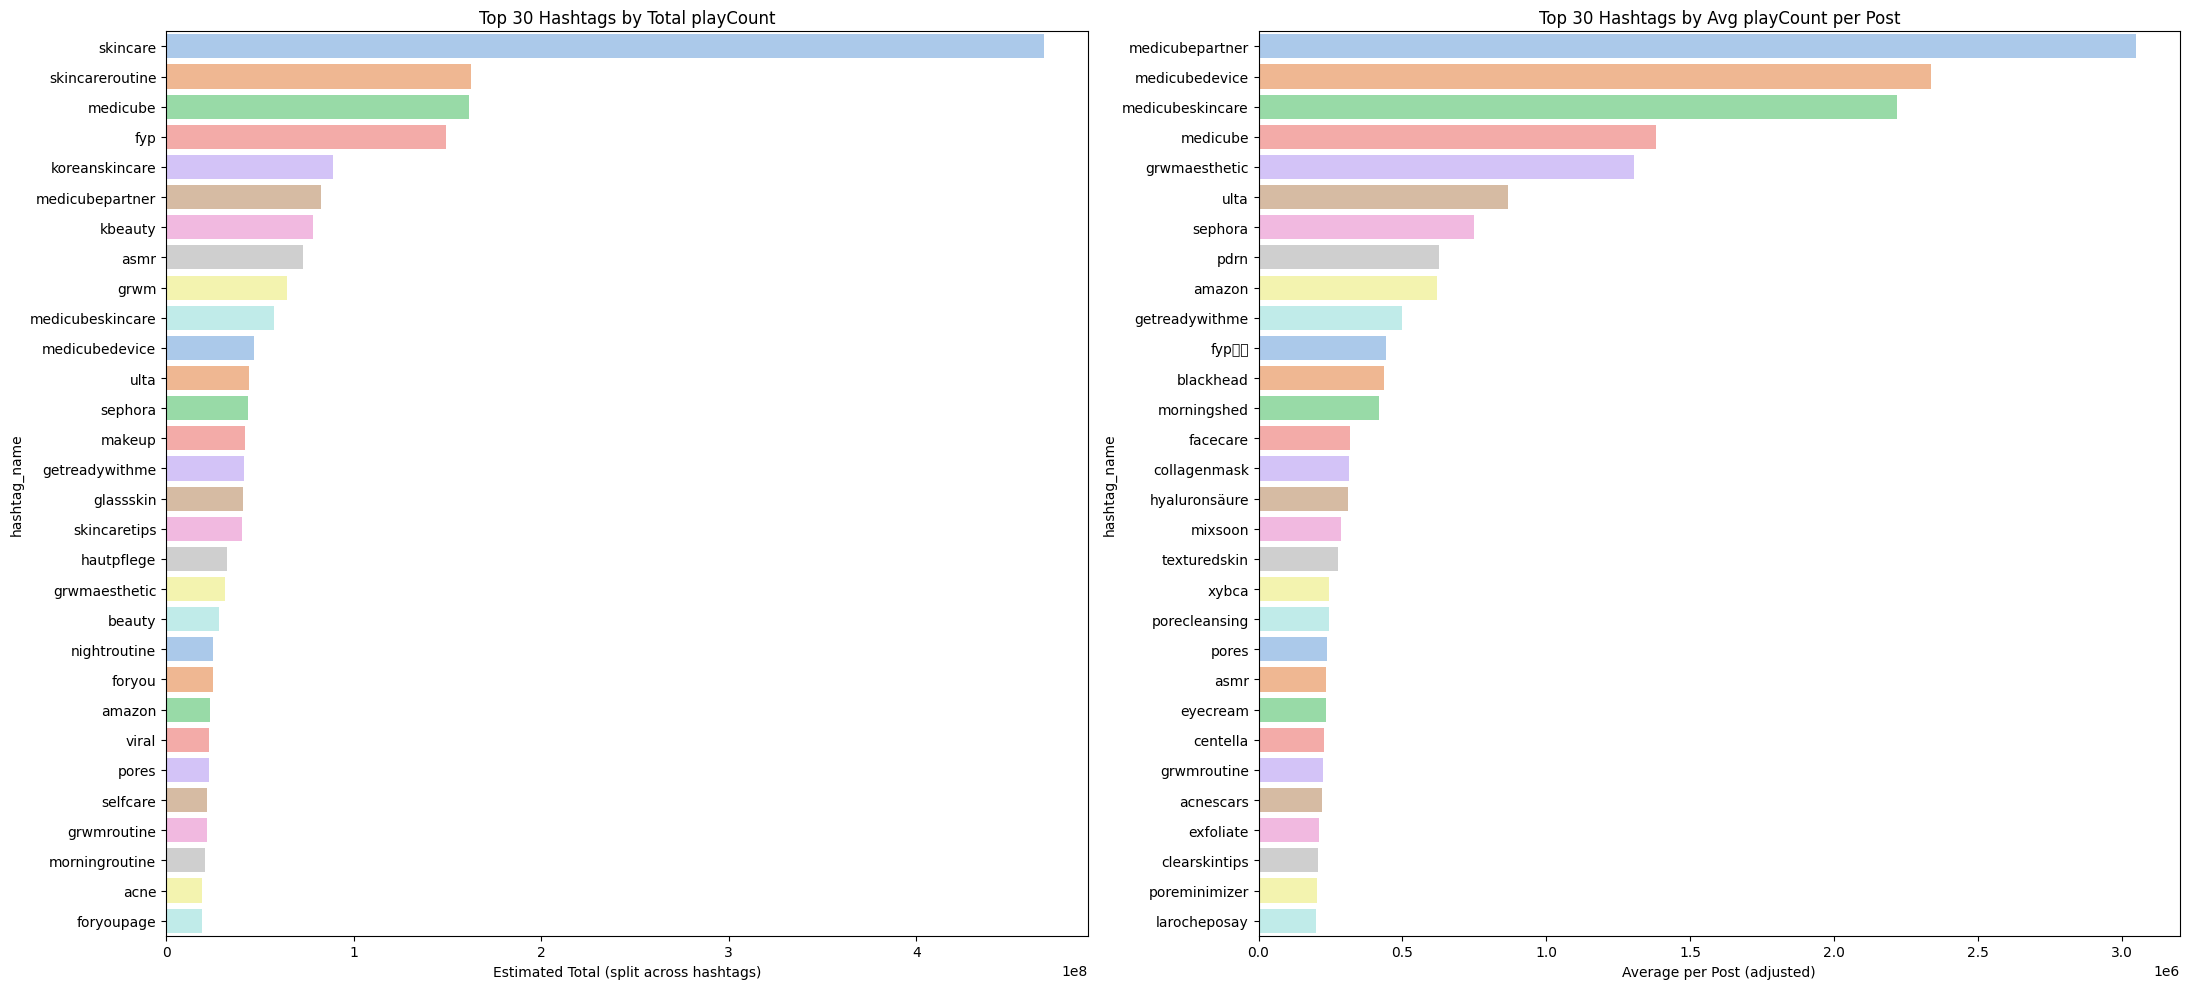

/var/folders/rx/4hst61c96_bfm0gnxrq_5w_h0000gn/T/ipykernel_73744/2447404667.py:62: UserWarning: Glyph 12471 (\N{KATAKANA LETTER SI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/rx/4hst61c96_bfm0gnxrq_5w_h0000gn/T/ipykernel_73744/2447404667.py:62: UserWarning: Glyph 12442 (\N{COMBINING KATAKANA-HIRAGANA SEMI-VOICED SOUND MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/hannahschlaucher/Library/Caches/pypoetry/virtualenvs/skincare-analysis-pFfgqJ8c-py3.10/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12471 (\N{KATAKANA LETTER SI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/hannahschlaucher/Library/Caches/pypoetry/virtualenvs/skincare-analysis-pFfgqJ8c-py3.10/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12442 (\N{COMBINING KATAKANA-HIRAGANA SEMI-VOICED SOUND MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw

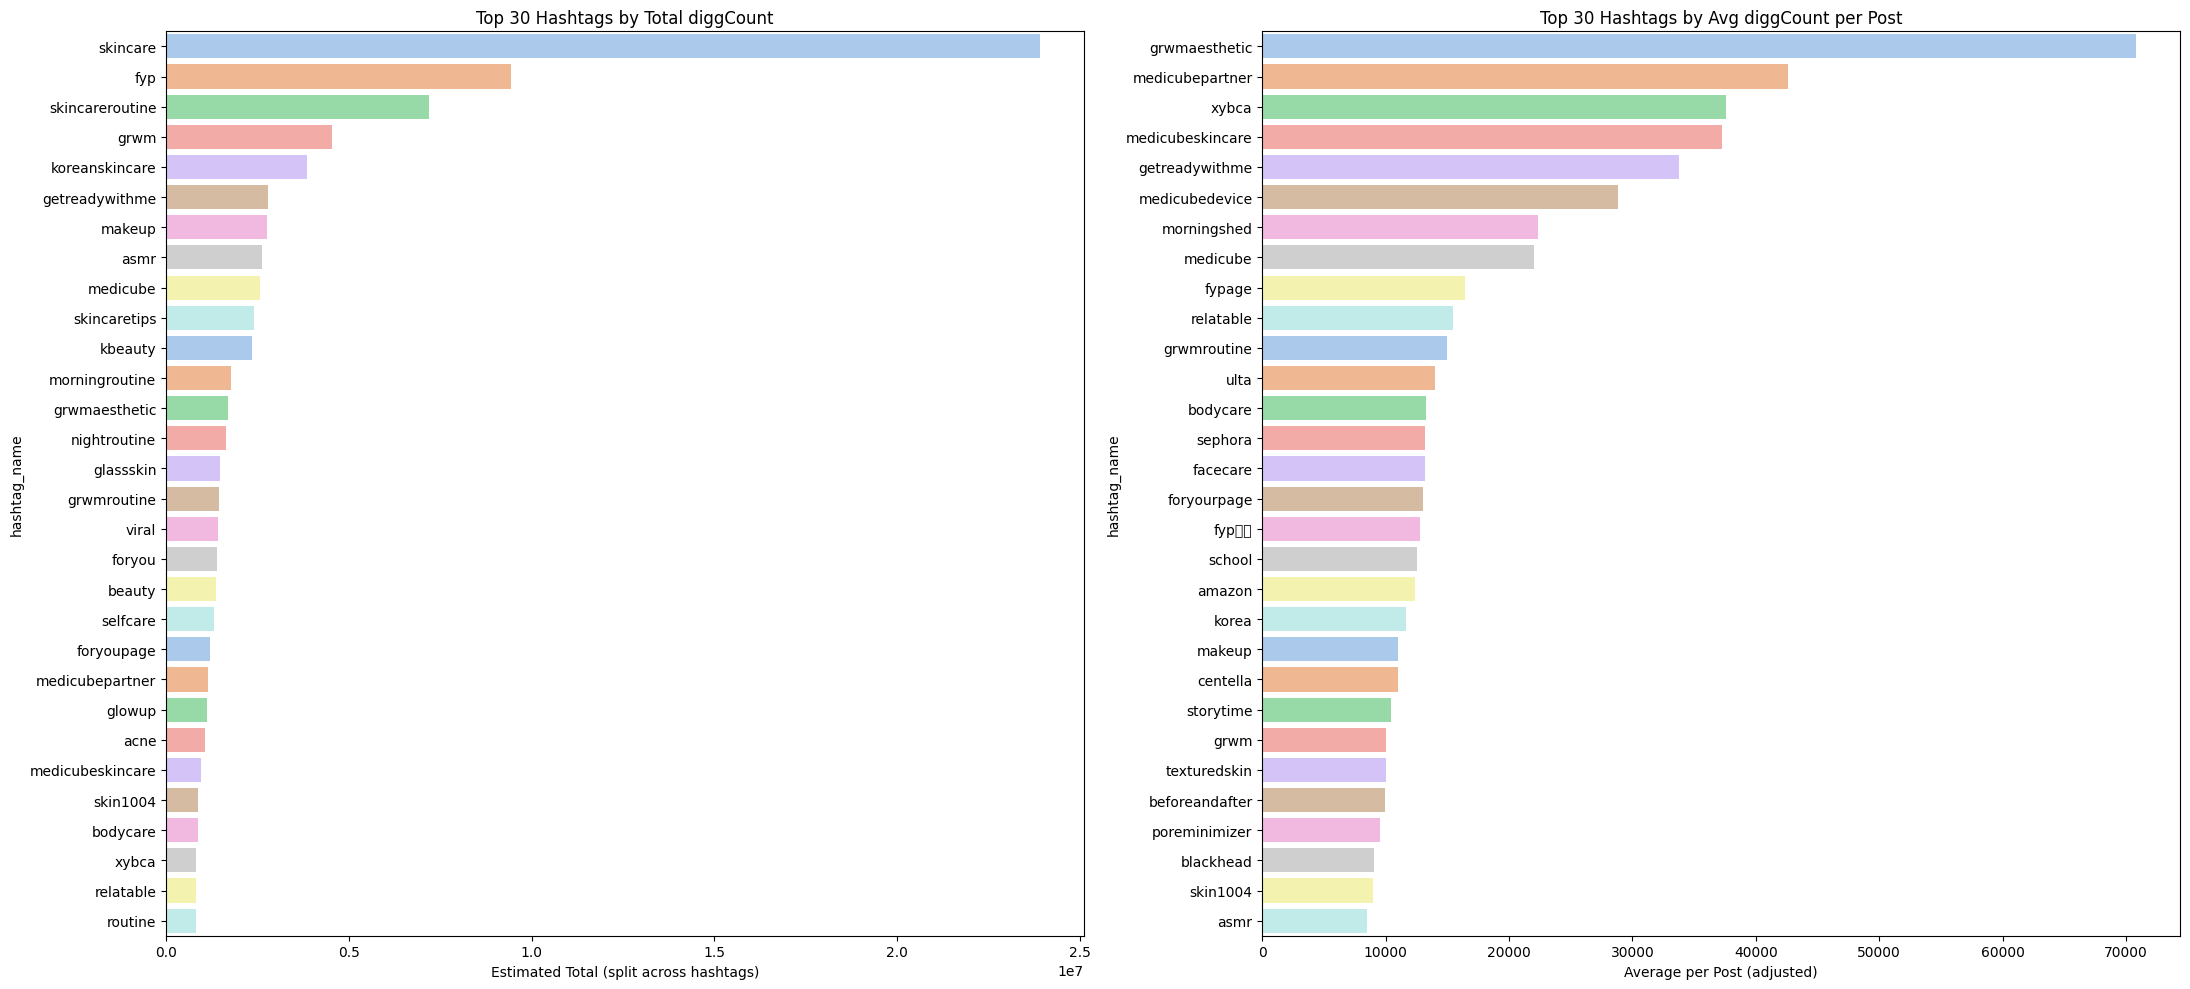

/var/folders/rx/4hst61c96_bfm0gnxrq_5w_h0000gn/T/ipykernel_73744/2447404667.py:62: UserWarning: Glyph 12471 (\N{KATAKANA LETTER SI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/rx/4hst61c96_bfm0gnxrq_5w_h0000gn/T/ipykernel_73744/2447404667.py:62: UserWarning: Glyph 12442 (\N{COMBINING KATAKANA-HIRAGANA SEMI-VOICED SOUND MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/hannahschlaucher/Library/Caches/pypoetry/virtualenvs/skincare-analysis-pFfgqJ8c-py3.10/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12471 (\N{KATAKANA LETTER SI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/hannahschlaucher/Library/Caches/pypoetry/virtualenvs/skincare-analysis-pFfgqJ8c-py3.10/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12442 (\N{COMBINING KATAKANA-HIRAGANA SEMI-VOICED SOUND MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw

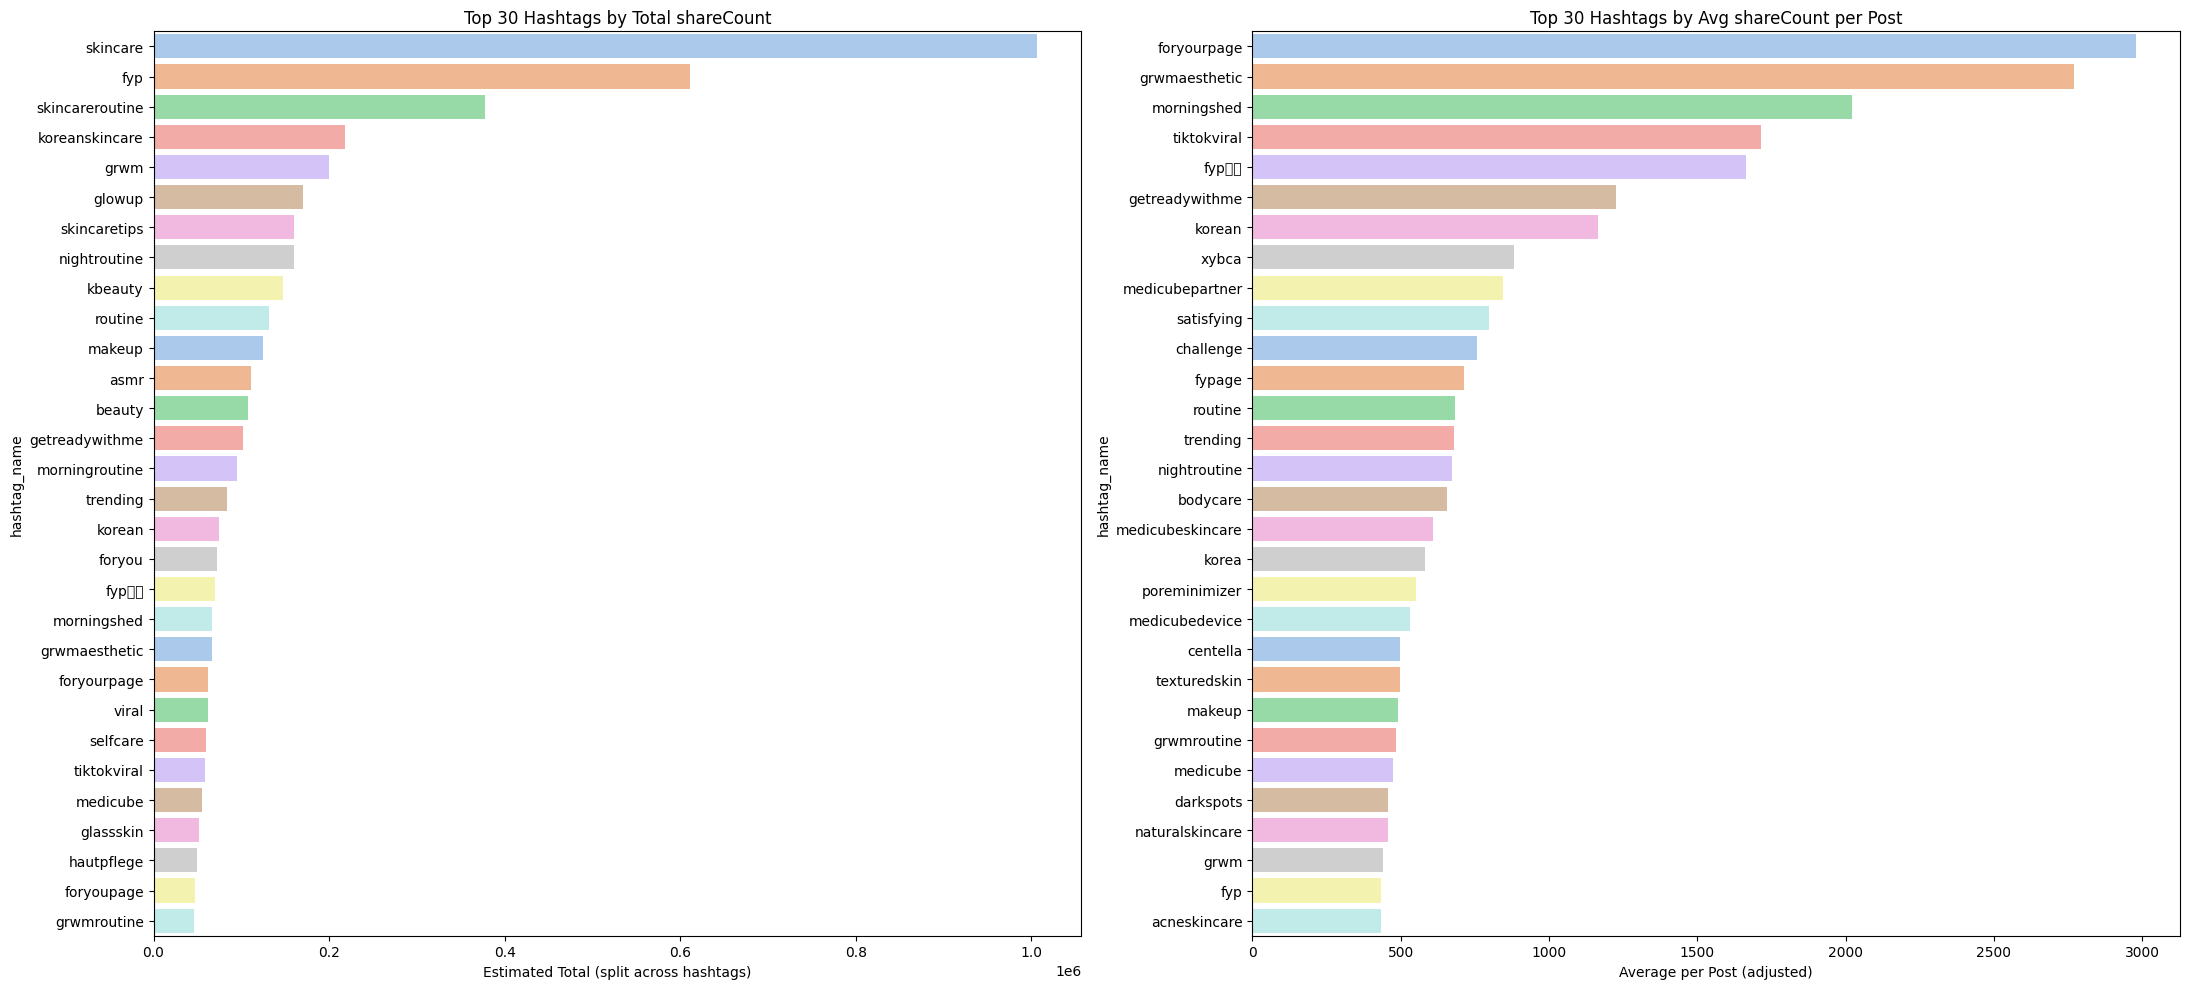

/var/folders/rx/4hst61c96_bfm0gnxrq_5w_h0000gn/T/ipykernel_73744/2447404667.py:62: UserWarning: Glyph 12471 (\N{KATAKANA LETTER SI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/rx/4hst61c96_bfm0gnxrq_5w_h0000gn/T/ipykernel_73744/2447404667.py:62: UserWarning: Glyph 12442 (\N{COMBINING KATAKANA-HIRAGANA SEMI-VOICED SOUND MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/hannahschlaucher/Library/Caches/pypoetry/virtualenvs/skincare-analysis-pFfgqJ8c-py3.10/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12471 (\N{KATAKANA LETTER SI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/hannahschlaucher/Library/Caches/pypoetry/virtualenvs/skincare-analysis-pFfgqJ8c-py3.10/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12442 (\N{COMBINING KATAKANA-HIRAGANA SEMI-VOICED SOUND MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw

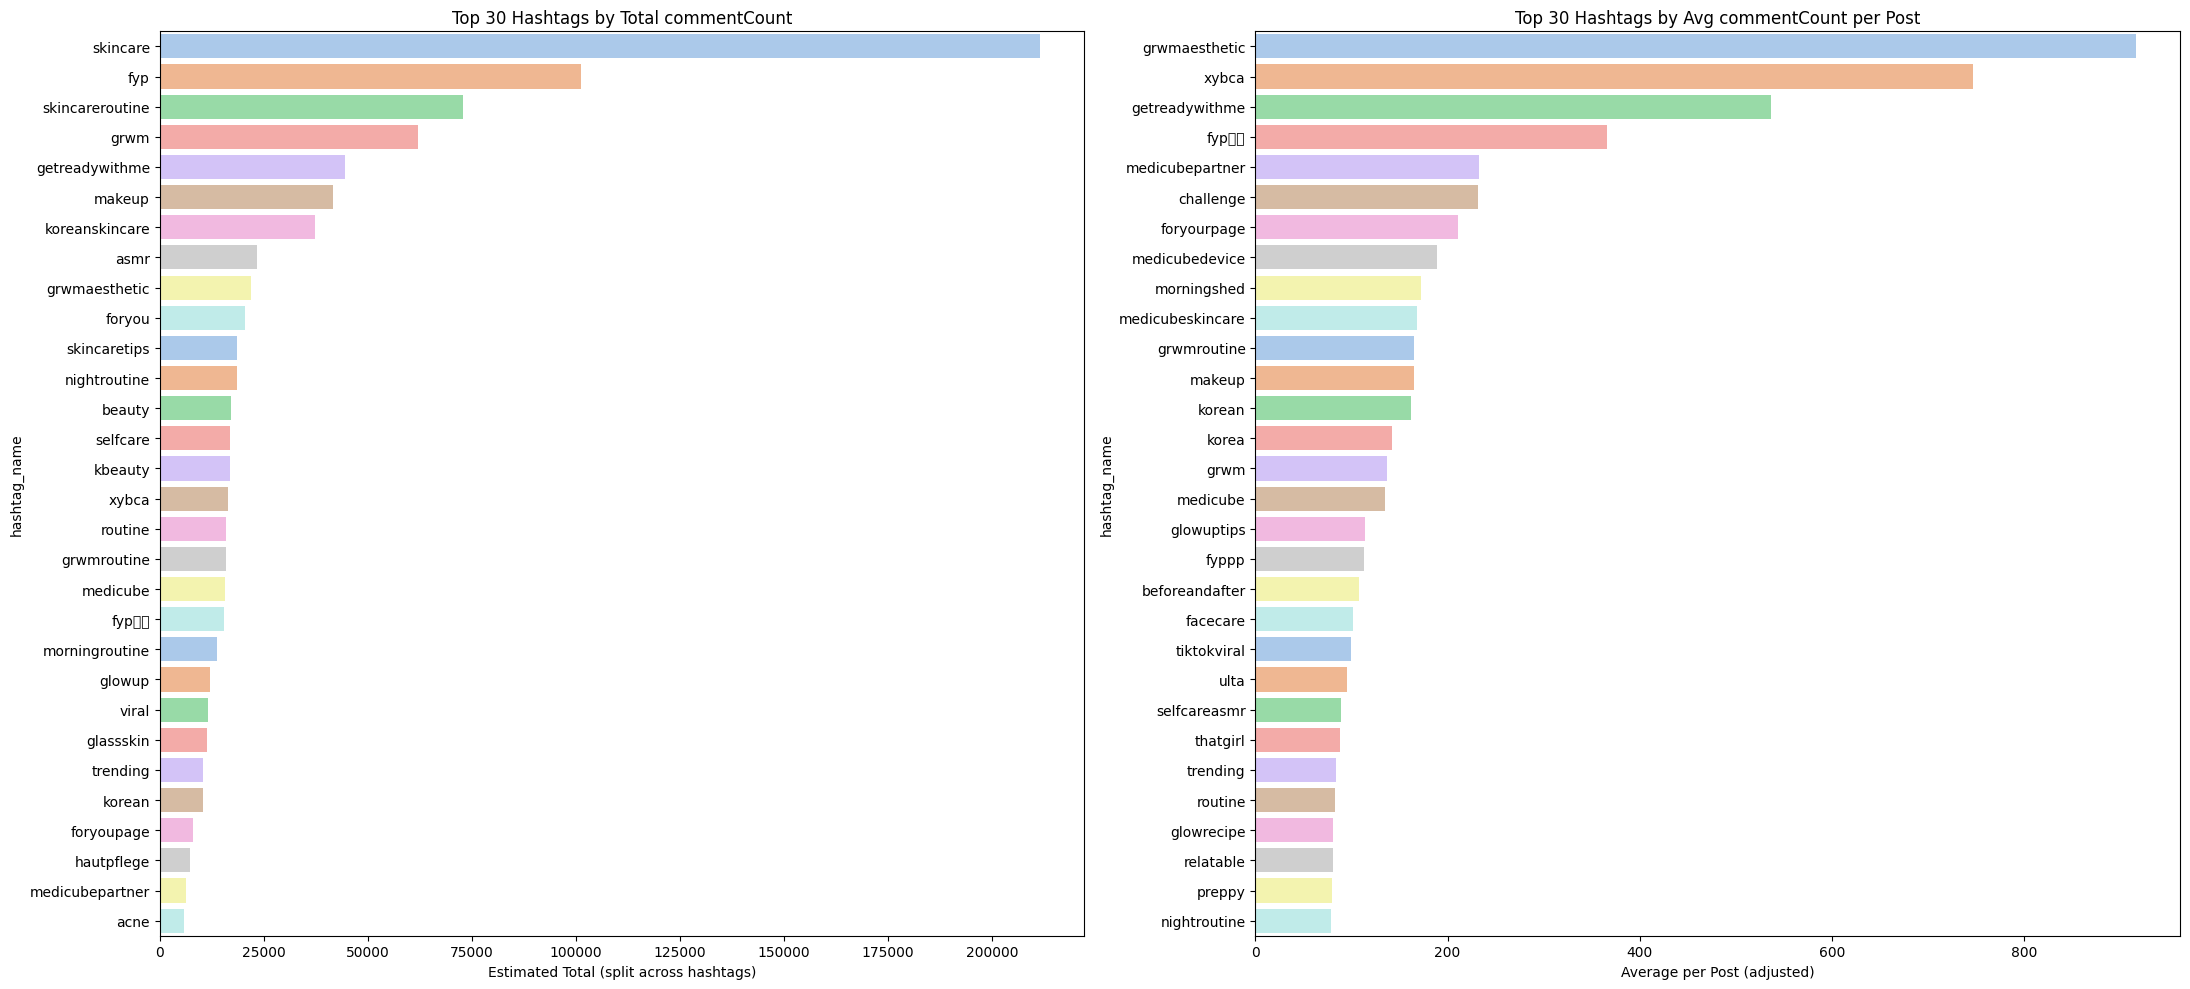

In [92]:
#Let's look at the number of views for each Hashtag

# number of hashtags per post
data_hashtags['hashtag_count'] = data_hashtags.groupby('post_id')['hashtag_name'].transform('count')

# Distribute metric
for metric in ['playCount', 'diggCount', 'shareCount', 'commentCount']:
    data_hashtags[f'{metric}_per_hashtag'] = data_hashtags[metric] / data_hashtags['hashtag_count']

def plot_sum_and_avg_by_metric(data):
    metrics = ['playCount', 'diggCount', 'shareCount', 'commentCount']
    
    # Calculate fair share per hashtag
    data['hashtag_count'] = data.groupby('post_id')['hashtag_name'].transform('count')
    for metric in metrics:
        data[f'{metric}_per_hashtag'] = data[metric] / data['hashtag_count']
    
    for metric in metrics:
        metric_col = f'{metric}_per_hashtag'
        
        agg = (
            data.groupby('hashtag_name')
            .agg(
                post_count=('post_id', 'nunique'),
                total_metric=(metric_col, 'sum')
            )
            .assign(avg_metric_per_post=lambda x: x['total_metric'] / x['post_count'])
        )

        # Filter: only hashtags with at least 30 posts
        agg = agg[agg['post_count'] >= 20]

        # Top 30 by total and by average
        top_total = agg.sort_values('total_metric', ascending=False).head(30)
        top_avg = agg.sort_values('avg_metric_per_post', ascending=False).head(30)

        # Plot
        fig, axes = plt.subplots(1, 2, figsize=(22, 10))

        sns.barplot(
            x=top_total['total_metric'],
            y=top_total.index,
            hue=top_total.index,
            palette='pastel',
            legend=False,
            ax=axes[0]
        )
        axes[0].set_title(f"Top 30 Hashtags by Total {metric}")
        axes[0].set_xlabel("Estimated Total (split across hashtags)")

        sns.barplot(
            x=top_avg['avg_metric_per_post'],
            y=top_avg.index,
            hue=top_avg.index,
            palette='pastel',
            legend=False,
            ax=axes[1]
        )
        axes[1].set_title(f"Top 30 Hashtags by Avg {metric} per Post")
        axes[1].set_xlabel("Average per Post (adjusted)")

        plt.tight_layout()
        plt.show()


plot_sum_and_avg_by_metric(data_hashtags)